# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import os
import keras

# 防止調用 GPU 報錯：Blas GEMM launch failed
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.8 #佔用 GPU 30% 的記憶體資源
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = [1e-2, 1e-3, 1e-5]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.3

In [10]:
OPTIMIZERS = ['SGD', 'RMSprop', 'AdaGrad', 'Adam']

results = {}
for opt in OPTIMIZERS:
    for lr in LEARNING_RATE:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Optimizer = %s, Learn Rate = %.6f" % (opt, lr))
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()

        if (opt == 'Adam'):
            optimizer = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
        elif (opt == 'SGD'):
            optimizer = keras.optimizers.SGD(lr=lr, momentum=0.3, decay=0.0, nesterov =True)
        elif (opt == 'RMSprop'):
            optimizer = keras.optimizers.RMSprop(lr=lr, rho=0.9, epsilon=None, decay=0.0)   
        elif (opt == 'AdaGrad'):
            optimizer = keras.optimizers.Adagrad(lr=lr, epsilon=None, decay=0.0)  

        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "%s-%s" % (opt, str(lr))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Experiment with Optimizer = SGD, Learn Rate = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [===

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 75us/step - loss: 2.2546 - acc: 0.1769 - val_loss: 2.1856 - val_acc: 0.2366
Epoch 2/50
50000/50000 [==============================] - 3s 62us/step - loss: 2.1446 - acc: 0.2587 - val_loss: 2.1047 - val_acc: 0.2759
Epoch 3/50
50000/50000 [==============================] - 3s 65us/step - loss: 2.0742 - acc: 0.2834 - val_loss: 2.0454 - val_acc: 0.2919
Epoch 4/50
50000/50000 [==============================] - 3s 64us/step - loss: 2.0221 - acc: 0.3005 - val_loss: 1.9990 - val_acc: 0.3125
Epoch 5/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.9809 - acc: 0.3126 - val_loss: 1.9645 - val_acc: 0.3194
Epoch 6/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.9478 - acc: 0.3230 - val_loss: 1.9343 - val_acc: 0.3257
Epoch 7/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.9206 - acc: 0.3304 - val_loss: 1.9123 - val_acc

50000/50000 [==============================] - 3s 59us/step - loss: 2.3472 - acc: 0.0921 - val_loss: 2.3415 - val_acc: 0.0915
Epoch 3/50
50000/50000 [==============================] - 3s 59us/step - loss: 2.3407 - acc: 0.0945 - val_loss: 2.3354 - val_acc: 0.0954
Epoch 4/50
50000/50000 [==============================] - 3s 59us/step - loss: 2.3348 - acc: 0.0969 - val_loss: 2.3298 - val_acc: 0.0967
Epoch 5/50
50000/50000 [==============================] - 3s 59us/step - loss: 2.3295 - acc: 0.0989 - val_loss: 2.3248 - val_acc: 0.0993
Epoch 6/50
50000/50000 [==============================] - 3s 61us/step - loss: 2.3247 - acc: 0.1013 - val_loss: 2.3202 - val_acc: 0.1036
Epoch 7/50
50000/50000 [==============================] - 3s 61us/step - loss: 2.3204 - acc: 0.1042 - val_loss: 2.3160 - val_acc: 0.1065
Epoch 8/50
50000/50000 [==============================] - 3s 64us/step - loss: 2.3163 - acc: 0.1068 - val_loss: 2.3121 - val_acc: 0.1104
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 3s 64us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 3s 62us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 3s 61us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 3s 61us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 3s 62us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 3s 61us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 3s 62us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 10/50
50000/50000 [=============

Epoch 4/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.7006 - acc: 0.3902 - val_loss: 1.6787 - val_acc: 0.4016
Epoch 5/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.6492 - acc: 0.4104 - val_loss: 1.5982 - val_acc: 0.4300
Epoch 6/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.6036 - acc: 0.4254 - val_loss: 1.6809 - val_acc: 0.4034
Epoch 7/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.5638 - acc: 0.4408 - val_loss: 1.7265 - val_acc: 0.3935
Epoch 8/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.5321 - acc: 0.4520 - val_loss: 1.6065 - val_acc: 0.4204
Epoch 9/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.5041 - acc: 0.4637 - val_loss: 1.5883 - val_acc: 0.4404
Epoch 10/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.4728 - acc: 0.4773 - val_loss: 1.6310 - val_acc: 0.4308
Epoch 11/50
50000/50000 [===============

50000/50000 [==============================] - 3s 62us/step - loss: 1.7995 - acc: 0.3728 - val_loss: 1.7956 - val_acc: 0.3745
Epoch 6/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.7713 - acc: 0.3834 - val_loss: 1.7684 - val_acc: 0.3774
Epoch 7/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.7479 - acc: 0.3915 - val_loss: 1.7470 - val_acc: 0.3914
Epoch 8/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.7274 - acc: 0.3994 - val_loss: 1.7344 - val_acc: 0.3938
Epoch 9/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.7086 - acc: 0.4061 - val_loss: 1.7102 - val_acc: 0.4103
Epoch 10/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.6922 - acc: 0.4109 - val_loss: 1.6995 - val_acc: 0.4111
Epoch 11/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.6775 - acc: 0.4159 - val_loss: 1.6885 - val_acc: 0.4093
Epoch 12/50
50000/50000 [=========================

50000/50000 [==============================] - 4s 70us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 3s 67us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 3s 66us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 3s 62us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 3s 63us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 11/50
50000/50000 [==============================] - 3s 63us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 12/50
50000/50000 [==============================] - 3s 64us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 13/50
50000/50000 [==========

Epoch 7/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.5967 - acc: 0.4394 - val_loss: 1.6191 - val_acc: 0.4264
Epoch 8/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.5763 - acc: 0.4481 - val_loss: 1.6229 - val_acc: 0.4234
Epoch 9/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.5586 - acc: 0.4571 - val_loss: 1.5856 - val_acc: 0.4411
Epoch 10/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.5427 - acc: 0.4593 - val_loss: 1.5685 - val_acc: 0.4464
Epoch 11/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.5299 - acc: 0.4647 - val_loss: 1.5425 - val_acc: 0.4569
Epoch 12/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.5161 - acc: 0.4695 - val_loss: 1.5517 - val_acc: 0.4502
Epoch 13/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.5043 - acc: 0.4742 - val_loss: 1.5629 - val_acc: 0.4494
Epoch 14/50
50000/50000 [============

50000/50000 [==============================] - 3s 64us/step - loss: 2.1488 - acc: 0.2618 - val_loss: 2.1454 - val_acc: 0.2640
Epoch 9/50
50000/50000 [==============================] - 3s 62us/step - loss: 2.1402 - acc: 0.2657 - val_loss: 2.1374 - val_acc: 0.2680
Epoch 10/50
50000/50000 [==============================] - 3s 63us/step - loss: 2.1324 - acc: 0.2699 - val_loss: 2.1300 - val_acc: 0.2729
Epoch 11/50
50000/50000 [==============================] - 3s 63us/step - loss: 2.1252 - acc: 0.2727 - val_loss: 2.1231 - val_acc: 0.2746
Epoch 12/50
50000/50000 [==============================] - 3s 62us/step - loss: 2.1184 - acc: 0.2755 - val_loss: 2.1166 - val_acc: 0.2768
Epoch 13/50
50000/50000 [==============================] - 3s 62us/step - loss: 2.1119 - acc: 0.2781 - val_loss: 2.1104 - val_acc: 0.2790
Epoch 14/50
50000/50000 [==============================] - 3s 62us/step - loss: 2.1058 - acc: 0.2802 - val_loss: 2.1045 - val_acc: 0.2807
Epoch 15/50
50000/50000 [======================

50000/50000 [==============================] - 3s 65us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 3s 66us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 11/50
50000/50000 [==============================] - 3s 64us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 12/50
50000/50000 [==============================] - 3s 66us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 13/50
50000/50000 [==============================] - 3s 64us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 14/50
50000/50000 [==============================] - 3s 64us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 15/50
50000/50000 [==============================] - 3s 63us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 16/50
50000/50000 [=======

Epoch 10/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.3513 - acc: 0.5151 - val_loss: 1.4383 - val_acc: 0.4890
Epoch 11/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.3276 - acc: 0.5274 - val_loss: 1.4160 - val_acc: 0.4983
Epoch 12/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.3028 - acc: 0.5348 - val_loss: 1.4354 - val_acc: 0.4922
Epoch 13/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.2732 - acc: 0.5440 - val_loss: 1.4116 - val_acc: 0.5012
Epoch 14/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.2596 - acc: 0.5481 - val_loss: 1.4034 - val_acc: 0.5047
Epoch 15/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.2351 - acc: 0.5608 - val_loss: 1.4057 - val_acc: 0.5054
Epoch 16/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.2095 - acc: 0.5673 - val_loss: 1.3958 - val_acc: 0.5099
Epoch 17/50
50000/50000 [=========

50000/50000 [==============================] - 3s 64us/step - loss: 1.6535 - acc: 0.4237 - val_loss: 1.6530 - val_acc: 0.4235
Epoch 12/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.6395 - acc: 0.4267 - val_loss: 1.6419 - val_acc: 0.4220
Epoch 13/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.6253 - acc: 0.4331 - val_loss: 1.6273 - val_acc: 0.4302
Epoch 14/50
50000/50000 [==============================] - 3s 67us/step - loss: 1.6133 - acc: 0.4393 - val_loss: 1.6188 - val_acc: 0.4298
Epoch 15/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.6002 - acc: 0.4424 - val_loss: 1.6163 - val_acc: 0.4364
Epoch 16/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.5889 - acc: 0.4478 - val_loss: 1.6002 - val_acc: 0.4355
Epoch 17/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.5788 - acc: 0.4489 - val_loss: 1.5879 - val_acc: 0.4427
Epoch 18/50
50000/50000 [=====================

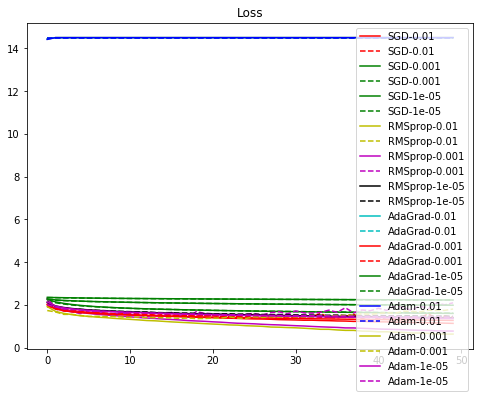

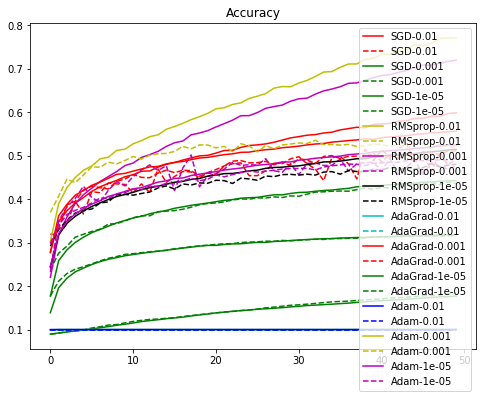

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "g", "y", "m", "k", "c","r", "g", "b", "y", "m"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()